In [1]:
import duckdb

# some DuckDB setup
con = duckdb.connect(database=':memory:')
# enable automatic query parallelization
con.execute("PRAGMA threads=2")
# enable caching of parquet metadata
con.execute("PRAGMA enable_object_cache")

In [2]:
train_data = "'../data/train-[1-8].parquet'"

In [3]:
con.execute(f"""

    select *
    from {train_data}

""").df()

,tconst,primaryTitle,originalTitle,startYear,endYear,runtimeMinutes,numVotes,label,__index_level_0__
0,tt0010600,The Doll,Die Puppe,1919,\N,66,1898.0,True,4
1,tt0011841,Way Down East,Way Down East,1920,\N,145,5376.0,True,7
2,tt0012494,Destiny,Der müde Tod,1921,\N,97,5842.0,True,9
3,tt0015163,The Navigator,The Navigator,1924,\N,59,9652.0,True,25
4,tt0016220,The Phantom of the Opera,The Phantom of the Opera,1925,\N,93,17887.0,True,38
...,...,...,...,...,...,...,...,...,...
7954,tt9625664,Trauma Center,None,2019,\N,87,12951.0,False,9966
7955,tt9741310,Slaxx,Slaxx,2020,\N,77,2464.0,False,9981
7956,tt9742392,Kindred,Kindred,2020,\N,101,1719.0,False,9982
7957,tt9850386,The Bee Gees: How Can You Mend a Broken Heart,None,2020,\N,111,4144.0,True,9996


# 1. Create train and test split from the beginning for comparability

In [4]:
film_ids = con.execute(f"""
    select distinct tconst,
        label
    from {train_data}
    """).df()

In [5]:
from sklearn.model_selection import train_test_split

# Split training data in train and test split

ids = film_ids.drop('label', axis=1).values
labels = film_ids.loc[:, 'label'].values

# Small test size because cross-validation (and want to train on more data)
X_train_ids, X_test_ids, y_train, y_test = train_test_split(ids, labels, test_size=0.10, random_state=42, stratify=labels)


In [21]:
import pandas as pd
X_train_ids  = pd.DataFrame(X_train_ids, columns=['tconst'])
X_test_ids = pd.DataFrame(X_test_ids, columns=['label'])

X_train_ids.to_parquet("X_train_ids.parquet")
X_test_ids.to_parquet("X_test_ids.parquet")


In [22]:
ids_train = "'X_train_ids.parquet'"
ids_test = "'X_test_ids.parquet'"

# 2. Establish Baseline

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import xgboost as xgb

### Dataset as it is

Dropping NaN in train set

In [34]:
# Load all the data into the duck database
baseline_data_train = con.execute(f"""
    with train as (
        select * 
        from {train_data}
    )
 select tconst, 
        try_cast(startYear as integer) as year,
        try_cast(runtimeMinutes as integer) as runtime, 
        try_cast(numVotes as integer) as votes,
        CASE
           WHEN originalTitle IS NULL THEN 0
           ELSE 1
        END AS ForeignFilm,
        -- Count number of words in title
        LENGTH(primaryTitle) - LENGTH(REPLACE(primaryTitle, ' ', '')) + 1 AS n_words,
        label
    from train
    where train.tconst in (select tconst from {ids_train})

""").df()

In [35]:
# Load all the data into the duck database
baseline_data_test = con.execute(f"""
    with train as (
        select * 
        from {train_data}
    )
    select tconst, 
        try_cast(startYear as integer) as year,
        try_cast(runtimeMinutes as integer) as runtime, 
        try_cast(numVotes as integer) as votes,
        CASE
           WHEN originalTitle IS NULL THEN 0
           ELSE 1
        END AS ForeignFilm,
        -- Count number of words in title
        LENGTH(primaryTitle) - LENGTH(REPLACE(primaryTitle, ' ', '')) + 1 AS n_words,
        label
    from train
    where train.tconst in (select tconst from {ids_test})

""").df()

In [36]:
baseline_data_train_noNAN = baseline_data_train.dropna()

In [37]:
X_train = baseline_data_train_noNAN.drop(['tconst',  'label'], axis=1).values
y_train = baseline_data_train_noNAN.loc[:, 'label'].values

In [38]:
print(X_train.shape)
print(y_train.shape)

(5812, 5)
(5812,)


In [39]:
X_test = baseline_data_test.drop(['tconst',  'label'], axis=1).values
y_test = baseline_data_test.loc[:, 'label'].values

In [41]:
print(X_test.shape)
print(y_test.shape)

(7959, 5)
(7959,)


In [42]:
# Preprocessing pipeline
preprocessing = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
])

# Base model pipelines
models = {
    'XGBoost': Pipeline(steps=[('preprocessing', preprocessing), ('classifier', xgb.XGBClassifier())])
}

hyperparameters = {
    'XGBoost': {
        'classifier__n_estimators': [50, 100, 150, 200],
        'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'classifier__max_depth': [2, 3, 4, 5],
        'classifier__subsample': [0.8, 1.0]
    }
}

best_models = {}
for model_name, model_pipeline in models.items():
    # Create a GridSearchCV object
    grid_search = GridSearchCV(model_pipeline, hyperparameters[model_name], cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

    # Fit the model
    grid_search.fit(X_train, y_train)

    # Store the best model
    best_models[model_name] = grid_search.best_estimator_

    # Print the best parameters and the best score
    print(f"{model_name} best parameters: {grid_search.best_params_}")
    print(f"{model_name} best score: {grid_search.best_score_:.4f}")

    # Use the best estimator to make predictions
    y_pred = grid_search.best_estimator_.predict(X_test)

    # Test if adjusting the threshold helps improve the accuracy (knowing dataset is balanced)
    y_proba = grid_search.best_estimator_.predict_proba(X_test)[:,1]
    threshold = np.median(y_proba)
    y_pred_th = (y_proba >= threshold).astype(int)

    # Calculate and print the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}% {accuracy_score(y_test, y_pred_th) * 100:.2f}%")

    # Print the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(conf_matrix)

    # Print the classification report
    class_report = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(class_report)

    # See how balanced the predictions are
    print (y_train.mean(), y_test.mean(), y_pred.mean(), threshold)

Fitting 5 folds for each of 128 candidates, totalling 640 fits
XGBoost best parameters: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
XGBoost best score: 0.7355
Accuracy: 74.13% 73.99%
Confusion Matrix:
[[3095  874]
 [1185 2805]]
Classification Report:
              precision    recall  f1-score   support

       False       0.72      0.78      0.75      3969
        True       0.76      0.70      0.73      3990

    accuracy                           0.74      7959
   macro avg       0.74      0.74      0.74      7959
weighted avg       0.74      0.74      0.74      7959

0.5048176187198898 0.5013192612137203 0.4622440005025757 0.45897174


Keeping NaN and replacing and imputing them

In [43]:
X_train = baseline_data_train.drop(['tconst',  'label'], axis=1).values
y_train = baseline_data_train.loc[:, 'label'].values

In [44]:
X_test = baseline_data_test.drop(['tconst',  'label'], axis=1).values
y_test = baseline_data_test.loc[:, 'label'].values

In [50]:
# Preprocessing pipeline
preprocessing = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
])

# Base model pipelines
models = {
    'XGBoost': Pipeline(steps=[('preprocessing', preprocessing), ('classifier', xgb.XGBClassifier())])
}

hyperparameters = {
    'XGBoost': {
        'classifier__n_estimators': [50, 100, 150, 200],
        'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'classifier__max_depth': [2, 3, 4, 5],
        'classifier__subsample': [0.8, 1.0]
    }
}

best_models = {}
for model_name, model_pipeline in models.items():
    # Create a GridSearchCV object
    grid_search = GridSearchCV(model_pipeline, hyperparameters[model_name], cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

    # Fit the model
    grid_search.fit(X_train, y_train)

    # Store the best model
    best_models[model_name] = grid_search.best_estimator_

    # Print the best parameters and the best score
    print(f"{model_name} best parameters: {grid_search.best_params_}")
    print(f"{model_name} best score: {grid_search.best_score_:.4f}")

    # Use the best estimator to make predictions
    y_pred = grid_search.best_estimator_.predict(X_test)

    # Test if adjusting the threshold helps improve the accuracy (knowing dataset is balanced)
    y_proba = grid_search.best_estimator_.predict_proba(X_test)[:,1]
    threshold = np.median(y_proba)
    y_pred_th = (y_proba >= threshold).astype(int)

    # Calculate and print the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}% {accuracy_score(y_test, y_pred_th) * 100:.2f}%")

    # Print the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(conf_matrix)

    # Print the classification report
    class_report = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(class_report)

    # See how balanced the predictions are
    print (y_train.mean(), y_test.mean(), y_pred.mean(), threshold)

Fitting 5 folds for each of 128 candidates, totalling 640 fits
XGBoost best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 50, 'classifier__subsample': 0.8}
XGBoost best score: 0.7290
Accuracy: 75.96% 75.45%
Confusion Matrix:
[[3190  779]
 [1134 2856]]
Classification Report:
              precision    recall  f1-score   support

       False       0.74      0.80      0.77      3969
        True       0.79      0.72      0.75      3990

    accuracy                           0.76      7959
   macro avg       0.76      0.76      0.76      7959
weighted avg       0.76      0.76      0.76      7959

0.5013262599469496 0.5013192612137203 0.456715667797462 0.44629627


## Fixing the year issue

In [72]:
# Load all the data into the duck database
train_fixed_year = con.execute(f"""
    with train as (
        select * 
        from {train_data}
    )
 select tconst, 
        -- Merge start year and end year into single column
        CASE
            WHEN startYear LIKE '%N%' THEN endYear
            ELSE startYear
        END AS year,
        try_cast(runtimeMinutes as integer) as runtime, 
        try_cast(numVotes as integer) as votes,
        CASE
           WHEN originalTitle IS NULL THEN 0
           ELSE 1
        END AS ForeignFilm,
        -- Count number of words in title
        LENGTH(primaryTitle) - LENGTH(REPLACE(primaryTitle, ' ', '')) + 1 AS n_words,
        label
    from train
    where train.tconst in (select tconst from {ids_train})

""").df()

In [73]:
# Load all the data into the duck database
test_fixed_year = con.execute(f"""
    with train as (
        select * 
        from {train_data}
    )
    select tconst, 
        -- Merge start year and end year into single column
        CASE
            WHEN startYear LIKE '%N%' THEN endYear
            ELSE startYear
        END AS year,
        try_cast(runtimeMinutes as integer) as runtime, 
        try_cast(numVotes as integer) as votes,
        CASE
           WHEN originalTitle IS NULL THEN 0
           ELSE 1
        END AS ForeignFilm,
        -- Count number of words in title
        LENGTH(primaryTitle) - LENGTH(REPLACE(primaryTitle, ' ', '')) + 1 AS n_words,
        label
    from train
    where train.tconst in (select tconst from {ids_test})

""").df()

In [74]:
X_train = train_fixed_year.drop(['tconst',  'label'], axis=1).values
y_train = train_fixed_year.loc[:, 'label'].values

In [75]:
X_test = test_fixed_year.drop(['tconst',  'label'], axis=1).values
y_test = test_fixed_year.loc[:, 'label'].values

In [76]:
# Preprocessing pipeline
preprocessing = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
])

# Base model pipelines
models = {
    'XGBoost': Pipeline(steps=[('preprocessing', preprocessing), ('classifier', xgb.XGBClassifier())])
}

hyperparameters = {
    'XGBoost': {
        'classifier__n_estimators': [50, 100, 150, 200],
        'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'classifier__max_depth': [2, 3, 4, 5],
        'classifier__subsample': [0.8, 1.0]
    }
}

best_models = {}
for model_name, model_pipeline in models.items():
    # Create a GridSearchCV object
    grid_search = GridSearchCV(model_pipeline, hyperparameters[model_name], cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

    # Fit the model
    grid_search.fit(X_train, y_train)

    # Store the best model
    best_models[model_name] = grid_search.best_estimator_

    # Print the best parameters and the best score
    print(f"{model_name} best parameters: {grid_search.best_params_}")
    print(f"{model_name} best score: {grid_search.best_score_:.4f}")

    # Use the best estimator to make predictions
    y_pred = grid_search.best_estimator_.predict(X_test)

    # Test if adjusting the threshold helps improve the accuracy (knowing dataset is balanced)
    y_proba = grid_search.best_estimator_.predict_proba(X_test)[:,1]
    threshold = np.median(y_proba)
    y_pred_th = (y_proba >= threshold).astype(int)

    # Calculate and print the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}% {accuracy_score(y_test, y_pred_th) * 100:.2f}%")

    # Print the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(conf_matrix)

    # Print the classification report
    class_report = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(class_report)

    # See how balanced the predictions are
    print (y_train.mean(), y_test.mean(), y_pred.mean(), threshold)

Fitting 5 folds for each of 128 candidates, totalling 640 fits
XGBoost best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 50, 'classifier__subsample': 0.8}
XGBoost best score: 0.7290
Accuracy: 75.96% 75.45%
Confusion Matrix:
[[3190  779]
 [1134 2856]]
Classification Report:
              precision    recall  f1-score   support

       False       0.74      0.80      0.77      3969
        True       0.79      0.72      0.75      3990

    accuracy                           0.76      7959
   macro avg       0.76      0.76      0.76      7959
weighted avg       0.76      0.76      0.76      7959

0.5013262599469496 0.5013192612137203 0.456715667797462 0.44629627


# Adding additional features

In [56]:
# Combine all films listed in the writer/director files with the year of the film 
# (from training, validation and test data).
movie_year = con.execute('''
    SELECT tconst,
        CASE
            WHEN startYear LIKE '%N%' THEN endYear
            ELSE startYear
        END AS Year,
    FROM '../data/train-[1-8].parquet'
    UNION
    SELECT tconst,
        CASE
            WHEN startYear LIKE '%N%' THEN endYear
            ELSE startYear
        END AS Year,
    FROM '../data/test_hidden.parquet'
    UNION
    SELECT tconst,
        CASE
            WHEN startYear LIKE '%N%' THEN endYear
            ELSE startYear
        END AS Year,
    FROM '../data/validation_hidden.parquet'
    ORDER BY Year, tconst
''').df()

In [57]:
# Calculate the number of films worked on previously by the writers and directors
# Includes the current film

experience = con.execute('''
    with writers as (
        select *
        from '../data/writing.parquet'
    ), 
    directors as (
        select * 
        from '../data/directing.parquet'
    
    )
    SELECT tconst, Year, writer, director,
    COUNT(DISTINCT tconst) OVER(PARTITION BY writer ORDER BY Year, tconst) AS writer_experience,
    COUNT(DISTINCT tconst) OVER(PARTITION BY director ORDER BY Year, tconst) AS director_experience,
    FROM movie_year my
    LEFT JOIN writers ON writers.movie == my.tconst
    LEFT JOIN directors ON directors.movie == my.tconst
    ORDER BY Year, tconst
''').df()

In [58]:
# Load all the data into the duck database
train_features = con.execute(f"""
    with train as (
        select * 
        from {train_data}
    )
 select tconst, 
        -- Merge start year and end year into single column
        CASE
            WHEN startYear LIKE '%N%' THEN endYear
            ELSE startYear
        END AS year,
        try_cast(runtimeMinutes as integer) as runtime, 
        try_cast(numVotes as integer) as votes,
        CASE
           WHEN originalTitle IS NULL THEN 0
           ELSE 1
        END AS ForeignFilm,
        -- Count number of words in title
        LENGTH(primaryTitle) - LENGTH(REPLACE(primaryTitle, ' ', '')) + 1 AS n_words,
        label
    from train
    where train.tconst in (select tconst from {ids_train})

""").df()

In [59]:
# Load all the data into the duck database
test_features = con.execute(f"""
    with train as (
        select * 
        from {train_data}
    )
    select tconst, 
        -- Merge start year and end year into single column
        CASE
            WHEN startYear LIKE '%N%' THEN endYear
            ELSE startYear
        END AS year,
        try_cast(runtimeMinutes as integer) as runtime, 
        try_cast(numVotes as integer) as votes,
        CASE
           WHEN originalTitle IS NULL THEN 0
           ELSE 1
        END AS ForeignFilm,
        -- Count number of words in title
        LENGTH(primaryTitle) - LENGTH(REPLACE(primaryTitle, ' ', '')) + 1 AS n_words,
        label
    from train
    where train.tconst in (select tconst from {ids_test})

""").df()

In [60]:
# Merge movie data with the experience level of the writers and directors.
# For each film, calculate the number of writers/directors, average experience and total experience

train_all_features = con.execute('''
    SELECT 
      ANY_VALUE(td.tconst) AS tconst, 
      ANY_VALUE(td.Year) AS Year, 
      ANY_VALUE(runtime) AS runtimeMinutes,
      ANY_VALUE(ForeignFilm) AS ForeignFilm, 
      ANY_VALUE(n_words) AS n_words, 
      ANY_VALUE(votes) AS numVotes,
      COUNT(DISTINCT writer) AS n_writers,
      AVG(DISTINCT e.writer_experience) AS avgexp_writers,
      SUM(DISTINCT e.writer_experience) AS totexp_writers,
      COUNT(DISTINCT director) AS n_directors,
      AVG(DISTINCT e.director_experience) AS avgexp_directors,
      SUM(DISTINCT e.director_experience) AS totexp_directors,
      ANY_VALUE(label) AS label
    FROM train_features td
    LEFT JOIN experience e ON e.tconst == td.tconst
    GROUP BY td.tconst
''').df()

In [61]:
# Merge movie data with the experience level of the writers and directors.
# For each film, calculate the number of writers/directors, average experience and total experience

test_all_features = con.execute('''
    SELECT 
      ANY_VALUE(td.tconst) AS tconst, 
      ANY_VALUE(td.Year) AS Year, 
      ANY_VALUE(runtime) AS runtimeMinutes,
      ANY_VALUE(ForeignFilm) AS ForeignFilm, 
      ANY_VALUE(n_words) AS n_words, 
      ANY_VALUE(votes) AS numVotes,
      COUNT(DISTINCT writer) AS n_writers,
      AVG(DISTINCT e.writer_experience) AS avgexp_writers,
      SUM(DISTINCT e.writer_experience) AS totexp_writers,
      COUNT(DISTINCT director) AS n_directors,
      AVG(DISTINCT e.director_experience) AS avgexp_directors,
      SUM(DISTINCT e.director_experience) AS totexp_directors,
      ANY_VALUE(label) AS label
    FROM test_features td
    LEFT JOIN experience e ON e.tconst == td.tconst
    GROUP BY td.tconst
''').df()

In [62]:
X_train = train_all_features.drop(['tconst',  'label'], axis=1).values
y_train = train_all_features.loc[:, 'label'].values

In [63]:
X_test = test_all_features.drop(['tconst',  'label'], axis=1).values
y_test = test_all_features.loc[:, 'label'].values

In [64]:
# Preprocessing pipeline
preprocessing = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
])

# Base model pipelines
models = {
    'XGBoost': Pipeline(steps=[('preprocessing', preprocessing), ('classifier', xgb.XGBClassifier())])
}

hyperparameters = {
    'XGBoost': {
        'classifier__n_estimators': [50, 100, 150, 200],
        'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'classifier__max_depth': [2, 3, 4, 5],
        'classifier__subsample': [0.8, 1.0]
    }
}

best_models = {}
for model_name, model_pipeline in models.items():
    # Create a GridSearchCV object
    grid_search = GridSearchCV(model_pipeline, hyperparameters[model_name], cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

    # Fit the model
    grid_search.fit(X_train, y_train)

    # Store the best model
    best_models[model_name] = grid_search.best_estimator_

    # Print the best parameters and the best score
    print(f"{model_name} best parameters: {grid_search.best_params_}")
    print(f"{model_name} best score: {grid_search.best_score_:.4f}")

    # Use the best estimator to make predictions
    y_pred = grid_search.best_estimator_.predict(X_test)

    # Test if adjusting the threshold helps improve the accuracy (knowing dataset is balanced)
    y_proba = grid_search.best_estimator_.predict_proba(X_test)[:,1]
    threshold = np.median(y_proba)
    y_pred_th = (y_proba >= threshold).astype(int)

    # Calculate and print the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}% {accuracy_score(y_test, y_pred_th) * 100:.2f}%")

    # Print the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(conf_matrix)

    # Print the classification report
    class_report = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(class_report)

    # See how balanced the predictions are
    print (y_train.mean(), y_test.mean(), y_pred.mean(), threshold)

Fitting 5 folds for each of 128 candidates, totalling 640 fits
XGBoost best parameters: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 5, 'classifier__n_estimators': 50, 'classifier__subsample': 0.8}
XGBoost best score: 0.7038
Accuracy: 76.77% 76.98%
Confusion Matrix:
[[3242  727]
 [1122 2868]]
Classification Report:
              precision    recall  f1-score   support

       False       0.74      0.82      0.78      3969
        True       0.80      0.72      0.76      3990

    accuracy                           0.77      7959
   macro avg       0.77      0.77      0.77      7959
weighted avg       0.77      0.77      0.77      7959

0.5013262599469496 0.5013192612137203 0.4516899107928132 0.4436876


**All features**

In [65]:
# Load all the data into the duck database
train_features = con.execute(f"""
    with train as (
        select * 
        from {train_data}
    )
 select tconst, 
    -- Clean up the movie title text. Remove excess whitespace, convert to lowercase, convert non-ascii to ascii equivalent, 
        -- remove everything that is non-alpanumeric or a space.
        REGEXP_REPLACE(TRANSLATE(LOWER(TRIM(primaryTitle)), 'áàãäåæßçéèêíîïñòóôöøớúûüý','aaaaaabceeeiiinoooooouuuy'),'[^a-zA-Z0-9 ]','','g') AS pTitle,
        REGEXP_REPLACE(TRANSLATE(LOWER(TRIM(originalTitle)),'áàãäåæßçéèêíîïñòóôöøớúûüý','aaaaaabceeeiiinoooooouuuy'),'[^a-zA-Z0-9 ]','','g') AS oTitle,
        
        -- Merge start year and end year into single column
        CASE
            WHEN startYear LIKE '%N%' THEN endYear
            ELSE startYear
        END AS year,
        try_cast(runtimeMinutes as integer) as runtime, 
        try_cast(numVotes as integer) as votes,
        CASE
           WHEN originalTitle IS NULL THEN 0
           ELSE 1
        END AS ForeignFilm,
        -- Count number of words in title
        LENGTH(primaryTitle) - LENGTH(REPLACE(primaryTitle, ' ', '')) + 1 AS n_words,
        label
    from train
    where train.tconst in (select tconst from {ids_train})

""").df()

In [66]:
# Load all the data into the duck database
test_features = con.execute(f"""
    with train as (
        select * 
        from {train_data}
    )
    select tconst, 
       -- Clean up the movie title text. Remove excess whitespace, convert to lowercase, convert non-ascii to ascii equivalent, 
        -- remove everything that is non-alpanumeric or a space.
        REGEXP_REPLACE(TRANSLATE(LOWER(TRIM(primaryTitle)), 'áàãäåæßçéèêíîïñòóôöøớúûüý','aaaaaabceeeiiinoooooouuuy'),'[^a-zA-Z0-9 ]','','g') AS pTitle,
        REGEXP_REPLACE(TRANSLATE(LOWER(TRIM(originalTitle)),'áàãäåæßçéèêíîïñòóôöøớúûüý','aaaaaabceeeiiinoooooouuuy'),'[^a-zA-Z0-9 ]','','g') AS oTitle,
        
        -- Merge start year and end year into single column
        CASE
            WHEN startYear LIKE '%N%' THEN endYear
            ELSE startYear
        END AS year,
        try_cast(runtimeMinutes as integer) as runtime, 
        try_cast(numVotes as integer) as votes,
        CASE
           WHEN originalTitle IS NULL THEN 0
           ELSE 1
        END AS ForeignFilm,
        -- Count number of words in title
        LENGTH(primaryTitle) - LENGTH(REPLACE(primaryTitle, ' ', '')) + 1 AS n_words,
        label
    from train
    where train.tconst in (select tconst from {ids_test})

""").df()

In [67]:
# Merge movie data with the experience level of the writers and directors.
# For each film, calculate the number of writers/directors, average experience and total experience

train_fixed_title = con.execute('''
    SELECT 
    
      ANY_VALUE(td.tconst) AS tconst, 
      ANY_VALUE(td.Year) AS Year, 
      ANY_VALUE(runtime) AS runtimeMinutes,
      ANY_VALUE(ForeignFilm) AS ForeignFilm, 
      ANY_VALUE(n_words) AS n_words, 
      ANY_VALUE(votes) AS numVotes,
      COUNT(DISTINCT writer) AS n_writers,
      AVG(DISTINCT e.writer_experience) AS avgexp_writers,
      SUM(DISTINCT e.writer_experience) AS totexp_writers,
      COUNT(DISTINCT director) AS n_directors,
      AVG(DISTINCT e.director_experience) AS avgexp_directors,
      SUM(DISTINCT e.director_experience) AS totexp_directors,
      ANY_VALUE(label) AS label
    FROM train_features td
    LEFT JOIN experience e ON e.tconst == td.tconst
    GROUP BY td.tconst
''').df()

In [68]:
# Merge movie data with the experience level of the writers and directors.
# For each film, calculate the number of writers/directors, average experience and total experience

test_fixed_title = con.execute('''
    SELECT 
      ANY_VALUE(td.tconst) AS tconst, 
      ANY_VALUE(td.Year) AS Year, 
      ANY_VALUE(runtime) AS runtimeMinutes,
      ANY_VALUE(ForeignFilm) AS ForeignFilm, 
      ANY_VALUE(n_words) AS n_words, 
      ANY_VALUE(votes) AS numVotes,
      COUNT(DISTINCT writer) AS n_writers,
      AVG(DISTINCT e.writer_experience) AS avgexp_writers,
      SUM(DISTINCT e.writer_experience) AS totexp_writers,
      COUNT(DISTINCT director) AS n_directors,
      AVG(DISTINCT e.director_experience) AS avgexp_directors,
      SUM(DISTINCT e.director_experience) AS totexp_directors,
      ANY_VALUE(label) AS label
    FROM test_features td
    LEFT JOIN experience e ON e.tconst == td.tconst
    GROUP BY td.tconst
''').df()

In [69]:
X_train = train_fixed_title.drop(['tconst',  'label'], axis=1).values
y_train = train_fixed_title.loc[:, 'label'].values

In [70]:
X_test = test_fixed_title.drop(['tconst',  'label'], axis=1).values
y_test = test_fixed_title.loc[:, 'label'].values

In [71]:
# Preprocessing pipeline
preprocessing = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
])

# Base model pipelines
models = {
    'XGBoost': Pipeline(steps=[('preprocessing', preprocessing), ('classifier', xgb.XGBClassifier())])
}

hyperparameters = {
    'XGBoost': {
        'classifier__n_estimators': [50, 100, 150, 200],
        'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'classifier__max_depth': [2, 3, 4, 5],
        'classifier__subsample': [0.8, 1.0]
    }
}
best_models = {}
for model_name, model_pipeline in models.items():
    # Create a GridSearchCV object
    grid_search = GridSearchCV(model_pipeline, hyperparameters[model_name], cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

    # Fit the model
    grid_search.fit(X_train, y_train)

    # Store the best model
    best_models[model_name] = grid_search.best_estimator_

    # Print the best parameters and the best score
    print(f"{model_name} best parameters: {grid_search.best_params_}")
    print(f"{model_name} best score: {grid_search.best_score_:.4f}")

    # Use the best estimator to make predictions
    y_pred = grid_search.best_estimator_.predict(X_test)

    # Test if adjusting the threshold helps improve the accuracy (knowing dataset is balanced)
    y_proba = grid_search.best_estimator_.predict_proba(X_test)[:,1]
    threshold = np.median(y_proba)
    y_pred_th = (y_proba >= threshold).astype(int)

    # Calculate and print the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}% {accuracy_score(y_test, y_pred_th) * 100:.2f}%")

    # Print the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(conf_matrix)

    # Print the classification report
    class_report = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(class_report)

    # See how balanced the predictions are
    print (y_train.mean(), y_test.mean(), y_pred.mean(), threshold)

Fitting 5 folds for each of 128 candidates, totalling 640 fits
XGBoost best parameters: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
XGBoost best score: 0.7141
Accuracy: 76.72% 76.71%
Confusion Matrix:
[[3242  727]
 [1126 2864]]
Classification Report:
              precision    recall  f1-score   support

       False       0.74      0.82      0.78      3969
        True       0.80      0.72      0.76      3990

    accuracy                           0.77      7959
   macro avg       0.77      0.77      0.77      7959
weighted avg       0.77      0.77      0.77      7959

0.5013262599469496 0.5013192612137203 0.45118733509234826 0.44937167


In [78]:
data = {
    "Random Baseline": 0.5068,
    "Dirty Data (NaN dropped)": 0.7413, 
    "Dirty Daata (imputed)": 0.7596,
    "Clean data": 0.7596, 
    "+ writers + directors": 0.7677, 
    "+ Wikipedia data":  0.8400
}

In [79]:
import matplotlib.pyplot as plt

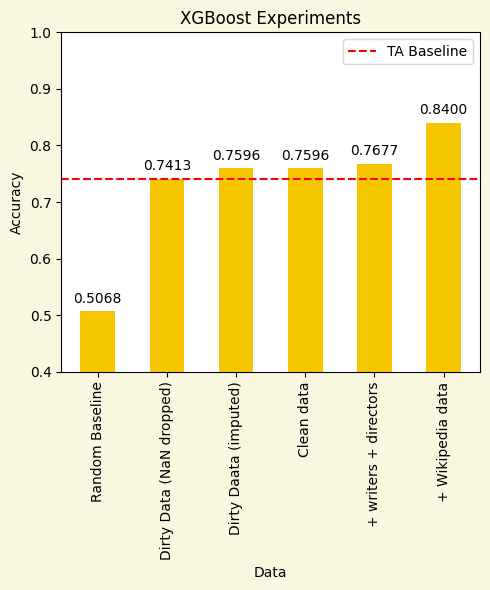

In [95]:
# Extracting labels and values from the data dictionary
labels = list(data.keys())
values = list(data.values())

# Creating the bar plot with slimmer bars
plt.figure(figsize=(5, 6), facecolor='#FAF7E0')  # smaller figsize
bars = plt.bar(labels, values, color='#F6C701', width=0.5)

# Adding title and labels
plt.title('XGBoost Experiments')
plt.xlabel('Data')
plt.ylabel('Accuracy')

# Setting y-axis limit to start from 0.4
plt.ylim(0.4, 1)

# Adding a red line at y=0.74 with legend
plt.axhline(y=0.74, color='red', linestyle='--', label='TA Baseline')
plt.legend()

# Rotating x-axis labels to 90 degrees for better readability
plt.xticks(rotation=90, ha='center')

# Adding the values on top of each bar
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, '{:.4f}'.format(val),
             ha='center', va='bottom', color='black')

# Displaying the plot
plt.tight_layout()

# Saving the plot as a PNG file
plt.savefig('experiments.png')  # specifying dpi for high resolution

# Show the plot
plt.show()